# WGAN_GP(Wassertein GAN Gradient Penalty)

### WGAN
$$L_D^{WGAN} = E[D(x)] - E[D(G(z))]$$

$$L_G^{WGAN} = E[D(G(z))]$$


### WGAN_GP
- Gradient Penalty

$$L_D^{WGAN\_GP} = L_D^{WGAN} + \lambda E[(|\nabla D(\alpha x - (1 - \alpha G(z))) | - 1)^2]$$

$$L_G^{WGAN\_GP} = L_G^{WGAN}$$

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Setting hyperparameters

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
z_dim = 62
sample_num = 64
beta1 = 0.5
beta2 = 0.999
lambda_ = 0.25
n_critics = 5

result_dir = './save_results/MNIST/WGAN_GP'
model_dir = './save_models/MNIST/WGAN_GP'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")

print(data_X.size())
print(data_Y.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([70000, 10])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim # 1
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        return x

## utils

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Optimizers

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

sample_z = torch.randn((batch_size, z_dim), requires_grad=False)

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

## 6. Load models

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/wgan_gp_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/wgan_gp_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [10]:
print(G)
print(D)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

## 7. Train

### WGAN_GP
- Gradient Penalty

$$L_D^{WGAN\_GP} = L_D^{WGAN} + \lambda E[(|\nabla D(\alpha x - (1 - \alpha G(z))) | - 1)^2]$$

$$L_G^{WGAN\_GP} = L_G^{WGAN}$$

In [11]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels =  real_labels.cuda()
    fake_labels = fake_labels.cuda()

In [12]:
D.train()
print('training start!!')
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    G.train()
    epoch_start_time = time.time()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]

        z = torch.rand((batch_size, z_dim))

        if USE_CUDA:
            images = images.cuda() 
            z = z.cuda()

        #============= Train the discriminator =============#
        # update D network
        d_optimizer.zero_grad()
        
        d_real = D(images)
        d_loss_real = -torch.mean(d_real)
            
        fake_images = G(z)
        d_fake = D(fake_images)
        d_loss_fake = torch.mean(d_fake)
            
        if USE_CUDA:
            alpha = torch.rand(images.size()).cuda()
        else:
            alpha = torch.rand(images.size())
        
        x_hat = Variable(alpha * images.data + (1 - alpha) * fake_images.data, requires_grad=True)
        
        pred_hat = D(x_hat)
        
        if USE_CUDA:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
        else:
            gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                            create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        gradient_penalty = lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()
        
        d_loss = d_loss_real + d_loss_fake + gradient_penalty
        
        d_loss.backward()
        d_optimizer.step()
        
        if ((iter + 1) % n_critics) == 0:
            # update G network
            g_optimizer.zero_grad()
            
            fake_images = G(z)
            d_fake = D(fake_images)
            g_loss = -torch.mean(d_fake)
            train_hist['g_loss'].append(g_loss.item())
            
            g_loss.backward()
            g_optimizer.step()
            train_hist['d_loss'].append(d_loss.item())
            
        
        if ((iter + 1) % 100) == 0:
            print('Epoch [%2d/%2d], Step [%4d/%4d], D_loss: %.8f, G_loss: %.8f'
                  %(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, d_loss.item(), g_loss.item()))
            
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # Save sample images
    samples = G(sample_z)
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/wgan_gp_generator.pkl')
torch.save(D.state_dict(), model_dir + '/wgan_gp_discriminator.pkl')

loss_plot(train_hist, result_dir, 'WGAN_GP')

training start!!
Epoch [ 1/30], Step [ 100/1093], D_loss: -0.32290173, G_loss: -0.53052032
Epoch [ 1/30], Step [ 200/1093], D_loss: -0.41675058, G_loss: -0.45724601
Epoch [ 1/30], Step [ 300/1093], D_loss: -0.41431591, G_loss: -0.46799362
Epoch [ 1/30], Step [ 400/1093], D_loss: -0.48458585, G_loss: -0.41854319
Epoch [ 1/30], Step [ 500/1093], D_loss: -0.56790912, G_loss: -0.34261939
Epoch [ 1/30], Step [ 600/1093], D_loss: -0.55880708, G_loss: -0.36053577
Epoch [ 1/30], Step [ 700/1093], D_loss: -0.65368050, G_loss: -0.27344331
Epoch [ 1/30], Step [ 800/1093], D_loss: -0.78527910, G_loss: -0.16341650
Epoch [ 1/30], Step [ 900/1093], D_loss: -0.74076009, G_loss: -0.19193855
Epoch [ 1/30], Step [1000/1093], D_loss: -0.71380788, G_loss: -0.19271517
Epoch [ 2/30], Step [ 100/1093], D_loss: -0.73122388, G_loss: -0.19238161
Epoch [ 2/30], Step [ 200/1093], D_loss: -0.72957826, G_loss: -0.19111308
Epoch [ 2/30], Step [ 300/1093], D_loss: -0.76331812, G_loss: -0.17434298
Epoch [ 2/30], Step [

Epoch [12/30], Step [ 200/1093], D_loss: -0.99443567, G_loss: -0.00066600
Epoch [12/30], Step [ 300/1093], D_loss: -0.99357063, G_loss: -0.00075063
Epoch [12/30], Step [ 400/1093], D_loss: -0.99410194, G_loss: -0.00077634
Epoch [12/30], Step [ 500/1093], D_loss: -0.99269736, G_loss: -0.00161084
Epoch [12/30], Step [ 600/1093], D_loss: -0.99443126, G_loss: -0.00104119
Epoch [12/30], Step [ 700/1093], D_loss: -0.99582499, G_loss: -0.00056144
Epoch [12/30], Step [ 800/1093], D_loss: -0.99482268, G_loss: -0.00093904
Epoch [12/30], Step [ 900/1093], D_loss: -0.99410051, G_loss: -0.00075603
Epoch [12/30], Step [1000/1093], D_loss: -0.99335837, G_loss: -0.00088099
Epoch [13/30], Step [ 100/1093], D_loss: -0.99679524, G_loss: -0.00073744
Epoch [13/30], Step [ 200/1093], D_loss: -0.99535626, G_loss: -0.00060635
Epoch [13/30], Step [ 300/1093], D_loss: -0.99579287, G_loss: -0.00092695
Epoch [13/30], Step [ 400/1093], D_loss: -0.99716693, G_loss: -0.00088979
Epoch [13/30], Step [ 500/1093], D_los

Epoch [23/30], Step [ 300/1093], D_loss: -0.82198679, G_loss: -0.05915570
Epoch [23/30], Step [ 400/1093], D_loss: -0.82206780, G_loss: -0.06538417
Epoch [23/30], Step [ 500/1093], D_loss: -0.77563530, G_loss: -0.07637958
Epoch [23/30], Step [ 600/1093], D_loss: -0.86891007, G_loss: -0.02675925
Epoch [23/30], Step [ 700/1093], D_loss: -0.84253812, G_loss: -0.04944024
Epoch [23/30], Step [ 800/1093], D_loss: -0.81780332, G_loss: -0.06433339
Epoch [23/30], Step [ 900/1093], D_loss: -0.78718919, G_loss: -0.07767119
Epoch [23/30], Step [1000/1093], D_loss: -0.77842790, G_loss: -0.07847349
Epoch [24/30], Step [ 100/1093], D_loss: -0.72620285, G_loss: -0.12286084
Epoch [24/30], Step [ 200/1093], D_loss: -0.86147481, G_loss: -0.03865497
Epoch [24/30], Step [ 300/1093], D_loss: -0.76889032, G_loss: -0.05546637
Epoch [24/30], Step [ 400/1093], D_loss: -0.84494382, G_loss: -0.04858708
Epoch [24/30], Step [ 500/1093], D_loss: -0.81042290, G_loss: -0.06415655
Epoch [24/30], Step [ 600/1093], D_los

## 8. Display generated data

In [13]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


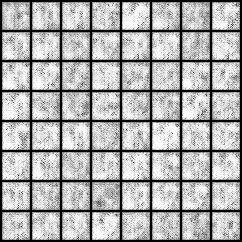

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use model to generate new sample

In [15]:
try:
    G.load_state_dict(torch.load(model_dir + '/wgan_gp_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/wgan_gp_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



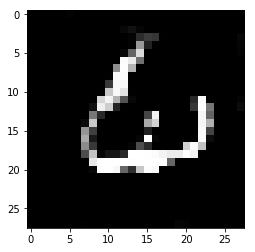

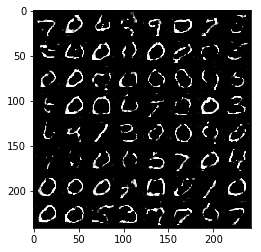

In [16]:
z = torch.randn(sample_num, z_dim)

if USE_CUDA:
    z = z.cuda()

G.eval()
fake_images = G(z)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()